In [80]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib inline
import numpy as np
from scipy.integrate import odeint
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
from matplotlib.ticker import LogLocator, NullFormatter
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from matplotlib import rcParams
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})


π = np.pi
Ω_cdm = 0.85
G = 6.67e-11                # in units of m^3⋅kg^−1⋅s^−2
t_i = 2.358e5                # in units of seconds
t_eq = 1.5923e12            # in units of seconds
ρ_eq = 2.1548e-16          # in units of kg m^-3
M_solar = 1.989e30        # in units of kg
c = 3e8                 #in units of m/s
A = 1.495e11                 # Astronomical unit
pc = 3.085e16               # in unist of meter. 
yr = 3.154e7              # in units of seconds
a_eq = 2.9374e-4

hbar = 1.0545718e-34        # reduced Planck constant in unkits of J.s
eV = 1.60218e-19               #in units of J
eV_to_kg = 1.7826e-36             #in units of kg
m_FDM_eV = 1e-22     #in units of eV/c²
m_FDM = m_FDM_eV * eV_to_kg      # Mass of FDM boson in units of kg


h = 0.67
ρ_c0= 1.9e-26 * (h**2) #kgm^-3  
Ω_r0 = 9.4e-5
Ω_m0 = 0.32
ρ_r0 = Ω_r0 * ρ_c0
ρ_m0 = Ω_m0 * ρ_c0
H_0 = np.sqrt((8 * π * G * ρ_c0)/3)




# Define event functions to detect turnaround points
def event_y_max(t, y, *args):
    return y[1]  # Detect velocity = 0 (turnaround)
event_y_max.terminal = False  
event_y_max.direction = -1  # Detect peak (expansion slowing down)



def event_y_min(t, y, *args):
    return y[1]  # Detect velocity = 0
event_y_min.terminal = True   # Stop at turnaround
event_y_min.direction = 1     # Detect minimum (collapse starts)



#def a(t): # as per RD
    #return np.sqrt(2 * H_0 * t)
    
#def rho_DM(t):
    #return 0.85 * ρ_m0 * (a(t)**-3)  

    
def a(t):
    return  np.sqrt(2 * t * (a_eq**2))  *  ((3/(4 * π * G * ρ_eq))**(-1/2))


def V_shell(r_outer, r_inner):
    return (4 * π / 3) * (r_outer**3 - r_inner**3)


def rho_DM(t):
    return (ρ_eq/2) * ((a(t)/a_eq)**(-3))  


def mfdm_shell_initial(r, t):
    return rho_DM(t) * ((4/3) * np.pi * (r**3)) 



def V_shell(r_outer, r_inner):
    #delta_r = r_outer - r_inner
    #if np.isclose(delta_r, 0, rtol=1e-12, atol=1e-20):
       # return 1e-10  
    #else:
    return (4/3) * np.pi * (r_outer**3 - r_inner**3)


def shells_mass(ri_arr, N, initial_density):
    m_shell = np.zeros(N)
    for j in range(N):
        if j == 0:
            m_shell[j] = initial_density * V_shell(ri_arr[j], 0)
        else:
            m_shell[j] = initial_density * V_shell(ri_arr[j], ri_arr[j-1])
    return m_shell


def shells_density(r_sol, delta_M_arr, N, rho_sol, t_arr, i, dt):
    delta_M_arr = shells_mass(ri_arr, N, initial_density)   
    rho_shell = np.zeros(N)
    for j in range(N - 1):
        if j == 0:
            delta_V = V_shell(r_sol[1, i], 0)
            rho_shell[j] = (delta_M_arr[1] + delta_M_arr[0])/delta_V #if delta_V > 0 else rho_sol[j, i-1]
        else:
            delta_Vj = V_shell(r_sol[j, i], r_sol[j-1, i])
            delta_Vj1 = V_shell(r_sol[j+1, i], r_sol[j, i])
            delta_Vsum = delta_Vj + delta_Vj1
            rho_shell[j] = (delta_M_arr[j] + delta_M_arr[j+1])/delta_Vsum #if delta_Vsum > 0 else rho_sol[j, i-1]

    delta_V_last = V_shell(r_sol[-1, i], r_sol[-2, i])
    rho_shell[-1] = delta_M_arr[-1]/delta_V_last #if delta_V_last > 0 else rho_sol[-1, i-1]
    return rho_shell




def qp_force_numerical(rho_var, r):
    rho_var = np.clip(rho_var, 1e-20, np.inf)
    grad_rho = np.gradient(rho_var, r, edge_order=2)
    laplacian_rho = (1/(r**2)) * np.gradient((r**2) * grad_rho, r, edge_order=2)
    qp_term = (laplacian_rho/rho_var) - ((1/2) * (grad_rho**2) / (rho_var**2))
    return (1/4) * np.gradient(qp_term, r, edge_order=2)




def shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP):
    rta_mask = [[] for _ in range(N)]
    tta_mask = [[] for _ in range(N)]
    for i in range(len(t_arr)):
        t = t_arr[i]
        dt_i = dt[i]
        rho_arr = shells_density(r_sol, delta_M_arr, N, rho_sol, t_arr, i, dt)
        #print(rho_arr)
        rho_sol[:, i] = rho_arr
        QP_arr = np.zeros(N)
        if QP==True:
            rho_var = rho_arr
            r_arr = r_sol[:, i]
            QP_arr = qp_force_numerical(rho_arr, r_arr) 
        else:
            QP_arr = np.zeros_like(r_sol[:, i])
        for j in range(N):
            if not mask_active[j]:
                continue
            dv_dt = 0
            if Hubble==True:
                dv_H_dt = -r_sol[j, i] / (4 * (t**2))
                dv_dt += dv_H_dt
            if gravity==True:
                dv_G_dt = -1 / (r_sol[j, i]**2) if r_sol[j, i] > 0 else 0
                dv_dt += dv_G_dt
            if QP==True:
                dv_QP_dt = QP_arr[j]
                dv_dt += dv_QP_dt
                #print(dv_dt)
            v_next = v_sol[j, i] + dv_dt * dt_i
            r_next = r_sol[j, i] + v_sol[j, i] * dt_i
            if not turnaround_detected[j]:
                rta_mask[j].append(r_sol[j, i])
                tta_mask[j].append(t_arr[i])
            if not turnaround_detected[j] and v_sol[j, i] > 0 and v_next < 0:
                turnaround_detected[j] = True
                t_ta_arr[j] = t_arr[i + 1]
                r_ta_arr[j] = r_next
                rta_mask[j].append(r_next)
                tta_mask[j].append(t_arr[i+1])
            #if turnaround_detected[j]:
               # mask_active[j] = False
                #cutoff_index[j] = i
               # continue
            if turnaround_detected[j]:
                after_steps = len(t_arr) - i
                rta_mask[j].extend([r_sol[j, i]] * after_steps)
                tta_mask[j].extend(t_arr[i:])
                r_sol[j, i + 1:] = r_sol[j, i]
                v_sol[j, i + 1:] = v_sol[j, i]
                mask_active[j] = False
                continue
            if i<len(t_arr)-1:
                r_sol[j, i + 1] = r_next
                v_sol[j, i + 1] = v_next
            else:
                r_sol[j, i] = r_sol[j, i-1]
                v_sol[j, i] = r_sol[j, i-1]
                
    return r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask

In [2]:
#rho vs t, keeping the number of shells fixed and increasing the 
# number of time steps

In [7]:
# initial conditions

t_i, t_f = 1e-15, 1e5
N = 20
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True


t_step = 10000
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])

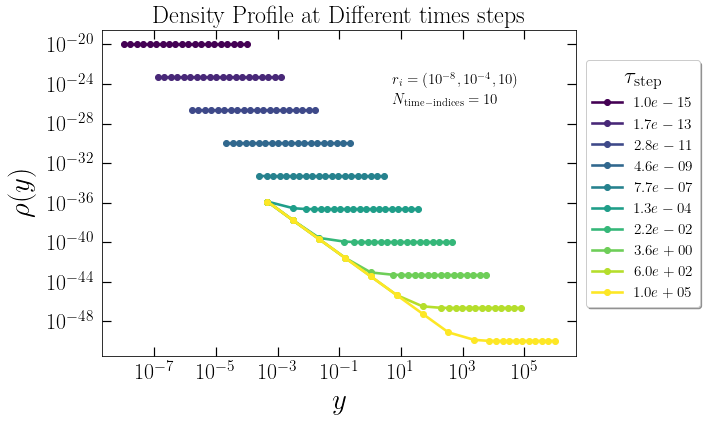

In [8]:
# with 10 time-steps

r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP)

#time_indices = [0, 100, 500, 999]
time_indices = np.linspace(0, t_step-1 , 10, dtype=int)
#print(time_indices)
#time_indices = [0, 2499, 4999, 7499, 9999]

fig, ax = plt.subplots(figsize=(8.5, 6))
plt.rc('lines', linewidth= 2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
#colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors = cm.viridis(np.linspace(0, 1, len(time_indices)))


for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    #print(r_at_time_index)
    rho_at_time_index = rho_sol[:, idx]
    #print(f"Step {i}, idx={idx}")
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
plt.text(5, 1e-24, '$r_i = (10^{-8}, 10^{-4}, 10)$', fontsize = 15)
plt.text(5, 1e-26, '$N_\mathrm{time-indices} = 10$', fontsize = 15 )
plt.xlabel(r'$y$', fontsize= 29, labelpad = 6)
plt.ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend( prop = {'size':15.2},loc = (1.02, 0.15),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
            facecolor = 'white',fontsize = 31)
plt.title(r'Density Profile at Different times steps', fontsize= 24)
plt.savefig('rhovsy_N20_t10.pdf', bbox_inches = 'tight')
plt.show()

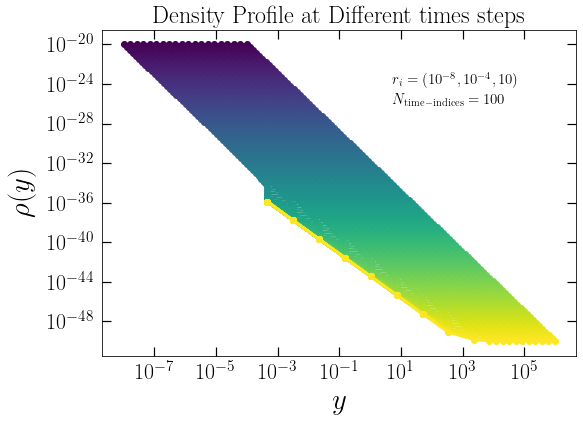

In [9]:
# with 100 time-steps

r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP)

#time_indices = [0, 100, 500, 999]
time_indices = np.linspace(0, t_step-1 , 100, dtype=int)
#print(time_indices)
#time_indices = [0, 2499, 4999, 7499, 9999]

fig, ax = plt.subplots(figsize=(8.5, 6))
plt.rc('lines', linewidth= 2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
#colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors = cm.viridis(np.linspace(0, 1, len(time_indices)))


for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    #print(r_at_time_index)
    rho_at_time_index = rho_sol[:, idx]
    #print(f"Step {i}, idx={idx}")
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)   
plt.text(5, 1e-24, '$r_i = (10^{-8}, 10^{-4}, 10)$', fontsize = 15)
plt.text(5, 1e-26, '$N_\mathrm{time-indices} = 100$', fontsize = 15 )
plt.xlabel(r'$y$', fontsize= 29, labelpad = 6)
plt.ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
#plt.legend( prop = {'size':15.2},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
         #   facecolor = 'white',fontsize = 31)
plt.title(r'Density Profile at Different times steps', fontsize= 24)
plt.savefig('rhovsy_N20_t100.pdf', bbox_inches = 'tight')
plt.show()

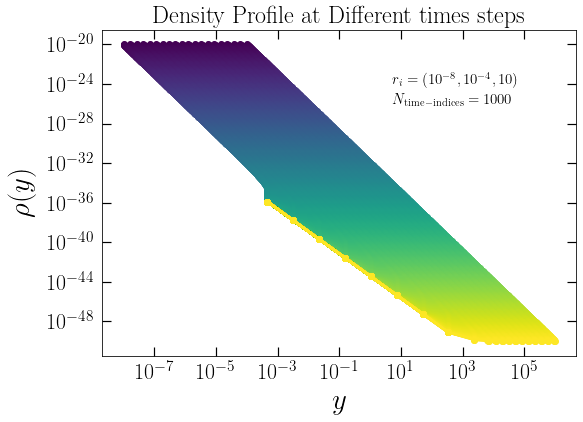

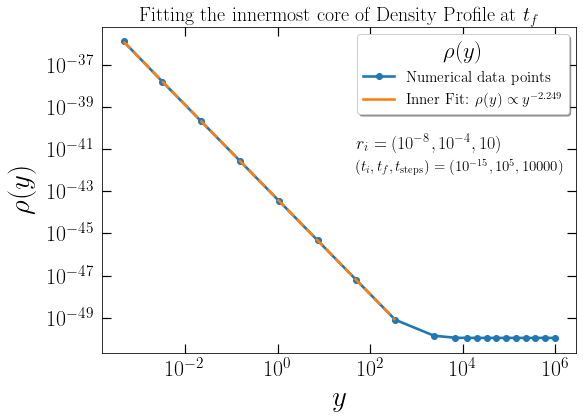

Fitted slope (inner core): \rho(y) \propto y^{-2.249}


In [11]:
# with 1000 time-steps


r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP)

#time_indices = [0, 100, 500, 999]
time_indices = np.linspace(0, t_step-1 , 1000, dtype=int)
#print(time_indices)
#time_indices = [0, 2499, 4999, 7499, 9999]

fig, ax = plt.subplots(figsize=(8.5, 6))
plt.rc('lines', linewidth= 2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
#colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors = cm.viridis(np.linspace(0, 1, len(time_indices)))


for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    #print(r_at_time_index)
    rho_at_time_index = rho_sol[:, idx]
    #print(f"Step {i}, idx={idx}")
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)   
plt.text(5, 1e-24, '$r_i = (10^{-8}, 10^{-4}, 10)$', fontsize = 15)
plt.text(5, 1e-26, '$N_\mathrm{time-indices} = 1000$', fontsize = 15 )
plt.xlabel(r'$y$', fontsize= 29, labelpad = 6)
plt.ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
#plt.legend( prop = {'size':15.2},loc = (1.02, 0.01),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
         #   facecolor = 'white',fontsize = 31)
plt.title(r'Density Profile at Different times steps', fontsize= 24)
plt.savefig('rhovsy_N20_t1000.pdf', bbox_inches = 'tight')
plt.show()




#Fitting the outer region of the density curve at final time t_f.
def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]

# Sorting the points in order of increasing radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Choosing the numbe of inner-most points at the last time step
inner_N = 8 
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]


log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_fit, b_fit = popt
rho_fit = 10** f_fitting(log_r_inner, *popt)




fig, ax = plt.subplots(figsize=(8.5, 6))
plt.rc('lines', linewidth= 2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')



ax.loglog(r_valid, rho_valid, 'o-', 'C0')
ax.loglog(r_inner, rho_fit,  'C1', ls = '--')

plt.text(50, 1e-41, '$r_i = (10^{-8}, 10^{-4}, 10)$', fontsize = 18)
plt.text(50, 1e-42, '$(t_i, t_f, t_\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize = 15 )


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)    
plt.xlabel(r'$y$', fontsize= 29, labelpad = 6)
plt.ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title('Fitting the innermost core of Density Profile at $t_f$', fontsize=20)
plt.legend(['Numerical data points', fr'Inner Fit: $\rho(y) \propto y^{{{m_fit:.3f}}}$'], 
           prop = {'size':15.2},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)

plt.savefig('innerdensityfit1.pdf', bbox_inches = 'tight')
plt.show()

print(fr'Fitted slope (inner core): \rho(y) \propto y^{{{m_fit:.3f}}}')


In [12]:
# keeping the time span same and just increasing the
# range of intial radii values


In [13]:
# increasing the range of intial radii values

t_i, t_f = 1e-15, 1e5
N = 50
r_min, r_max = 1e-15, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True

t_step = 10000
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])


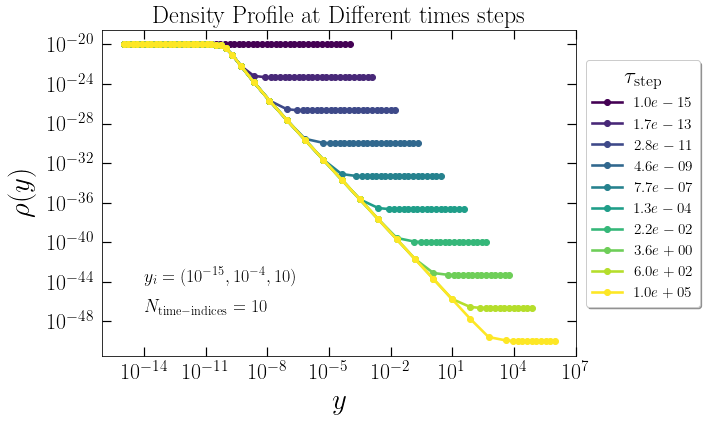

In [14]:
# with 10 time-steps


r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP)

#time_indices = [0, 100, 500, 999]
time_indices = np.linspace(0, t_step-1 , 10, dtype=int)
#print(time_indices)
#time_indices = [0, 2499, 4999, 7499, 9999]

fig, ax = plt.subplots(figsize=(8.5, 6))
plt.rc('lines', linewidth= 2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
#colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors = cm.viridis(np.linspace(0, 1, len(time_indices)))


for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    #print(r_at_time_index)
    rho_at_time_index = rho_sol[:, idx]
    #print(f"Step {i}, idx={idx}")
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
plt.text(1e-14, 1e-44, '$y_i = (10^{-15}, 10^{-4}, 10)$', fontsize = 18)
plt.text(1e-14, 1e-47, '$N_\mathrm{time-indices} = 10$', fontsize = 18)
plt.xlabel(r'$y$', fontsize= 29, labelpad = 6)
plt.ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend( prop = {'size':15.2},loc = (1.02, 0.15),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
            facecolor = 'white',fontsize = 31)
plt.title(r'Density Profile at Different times steps', fontsize= 24)
plt.savefig('rhovsy_N50_t10_diffyi.pdf', bbox_inches = 'tight')
plt.show()

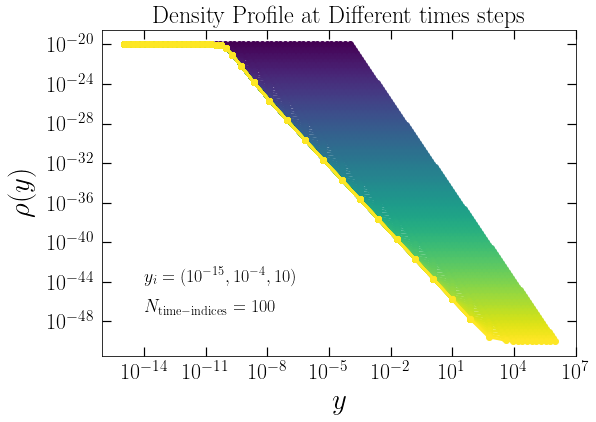

In [15]:
# with 100 time-steps

r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP)

#time_indices = [0, 100, 500, 999]
time_indices = np.linspace(0, t_step-1 , 100, dtype=int)
#print(time_indices)
#time_indices = [0, 2499, 4999, 7499, 9999]

fig, ax = plt.subplots(figsize=(8.5, 6))
plt.rc('lines', linewidth= 2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
#colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors = cm.viridis(np.linspace(0, 1, len(time_indices)))


for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    #print(r_at_time_index)
    rho_at_time_index = rho_sol[:, idx]
    #print(f"Step {i}, idx={idx}")
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
plt.text(1e-14, 1e-44, '$y_i = (10^{-15}, 10^{-4}, 10)$', fontsize = 18)
plt.text(1e-14, 1e-47, '$N_\mathrm{time-indices} = 100$', fontsize = 18)
plt.xlabel(r'$y$', fontsize= 29, labelpad = 6)
plt.ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
#plt.legend( prop = {'size':15.2},loc = (1.02, 0.15),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
            #facecolor = 'white',fontsize = 31)
plt.title(r'Density Profile at Different times steps', fontsize= 24)
plt.savefig('rhovsy_N50_t100_diffyi.pdf', bbox_inches = 'tight')
plt.show()

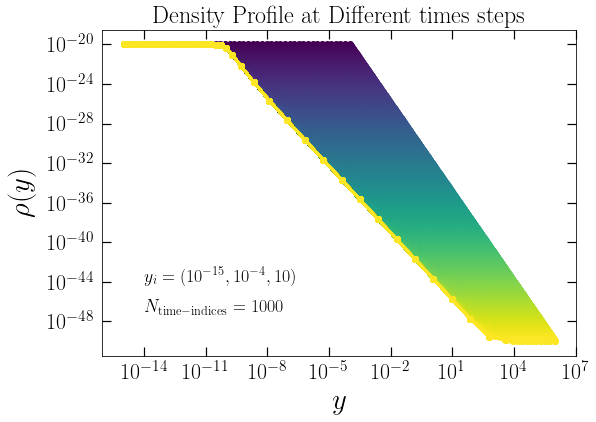

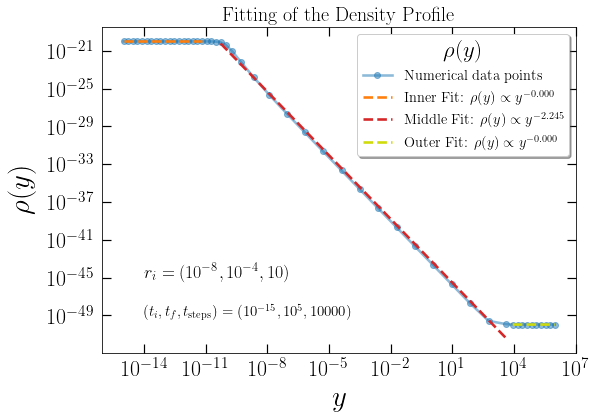

 Fitted slope (inner core):    \rho(y) \propto y^{-0.000}
Fitted slope (middle region): \rho(y) \propto y^{-2.245}
 Fitted slope (outer tail):    \rho(y) \propto y^{-0.000}


In [18]:
# with 100 time-steps

r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP)

#time_indices = [0, 100, 500, 999]
time_indices = np.linspace(0, t_step-1 , 1000, dtype=int)
#print(time_indices)
#time_indices = [0, 2499, 4999, 7499, 9999]

fig, ax = plt.subplots(figsize=(8.5, 6))
plt.rc('lines', linewidth= 2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
#colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors = cm.viridis(np.linspace(0, 1, len(time_indices)))


for i, idx in enumerate(time_indices):
    r_at_time_index = r_sol[:, idx]
    #print(r_at_time_index)
    rho_at_time_index = rho_sol[:, idx]
    #print(f"Step {i}, idx={idx}")
    ax.loglog(r_at_time_index, rho_at_time_index, marker='o', label=r'$ {0:.1e}$'.format(t_arr[idx]), color=colors[i])


ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)  
plt.text(1e-14, 1e-44, '$y_i = (10^{-15}, 10^{-4}, 10)$', fontsize = 18)
plt.text(1e-14, 1e-47, '$N_\mathrm{time-indices} = 1000$', fontsize = 18)
plt.xlabel(r'$y$', fontsize= 29, labelpad = 6)
plt.ylabel(r'$\rho(y)$', fontsize= 29, labelpad = 11)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
#plt.legend( prop = {'size':15.2},loc = (1.02, 0.15),shadow = True, title = r'$\tau_\mathrm{step}$' ,title_fontsize = 23,
            #facecolor = 'white',fontsize = 31)
plt.title(r'Density Profile at Different times steps', fontsize= 24)
plt.savefig('rhovsy_N50_t1000_diffyi.pdf', bbox_inches = 'tight')
plt.show()





###################################
# Fitting the density profile

def f_fitting(x, m, b):
    return (m*x) + b


final_idx = -1
r_final = r_sol[:, final_idx]
rho_final = rho_sol[:, final_idx]
mask = (r_final > 0) & (rho_final > 0)
r_valid = r_final[mask]
rho_valid = rho_final[mask]


# Sort by radius
sorted_idx = np.argsort(r_valid)
r_valid = r_valid[sorted_idx]
rho_valid = rho_valid[sorted_idx]

# Define regions
inner_N = 18
middle_start, middle_end = 21, 40
outer_N = 10

# Inner region
r_inner = r_valid[:inner_N]
rho_inner = rho_valid[:inner_N]
log_r_inner = np.log10(r_inner)
log_rho_inner = np.log10(rho_inner)
popt_inner, _ = curve_fit(f_fitting, log_r_inner, log_rho_inner)
m_inner, b_inner = popt_inner
rho_fit_inner = 10**f_fitting(log_r_inner, *popt_inner)

# Middle region
r_middle = r_valid[middle_start:middle_end]
rho_middle = rho_valid[middle_start:middle_end]
log_r_middle = np.log10(r_middle)
log_rho_middle = np.log10(rho_middle)
popt_middle, _ = curve_fit(f_fitting, log_r_middle, log_rho_middle)
m_middle, b_middle = popt_middle
rho_fit_middle = 10**f_fitting(log_r_middle, *popt_middle)

# Outer region
r_outer = r_valid[-outer_N:]
rho_outer = rho_valid[-outer_N:]
log_r_outer = np.log10(r_outer)
log_rho_outer = np.log10(rho_outer)
popt_outer, _ = curve_fit(f_fitting, log_r_outer, log_rho_outer)
m_outer, b_outer = popt_outer
rho_fit_outer = 10**f_fitting(log_r_outer, *popt_outer)


fig, ax = plt.subplots(figsize=(8.5, 6))
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')


ax.loglog(r_valid, rho_valid, 'o-', color='C0', alpha = 0.5)
ax.loglog(r_inner, rho_fit_inner, '--', color='C1')
ax.loglog(r_middle, rho_fit_middle, '--', color='C3')
ax.loglog(r_outer, rho_fit_outer, '--', color='#d0db0b')


plt.text(1e-14, 1e-45, '$r_i = (10^{-8}, 10^{-4}, 10)$', fontsize=18)
plt.text(1e-14, 1e-49, '$(t_i, t_f, t_\\mathrm{steps}) = (10^{-15}, 10^{5}, 10000)$', fontsize=15)

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9)
plt.xlabel(r'$y$', fontsize=29, labelpad=6)
plt.ylabel(r'$\rho(y)$', fontsize=29, labelpad=11)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.title('Fitting of the Density Profile', fontsize=20)
plt.legend(['Numerical data points', fr'Inner Fit: $\rho(y) \propto y^{{{m_inner:.3f}}}$',
           fr'Middle Fit: $\rho(y) \propto y^{{{m_middle:.3f}}}$', 
           fr'Outer Fit: $\rho(y) \propto y^{{{m_outer:.3f}}}$'], 
           prop = {'size':14.5},loc = 'upper right', shadow = True, 
           title = r'$\rho(y)$' ,title_fontsize = 23,
           facecolor = 'white',fontsize = 31)
plt.savefig('innerdensityfit2.pdf', bbox_inches = 'tight')
plt.show()


print(fr' Fitted slope (inner core):    \rho(y) \propto y^{{{m_inner:.3f}}}')
print(fr'Fitted slope (middle region): \rho(y) \propto y^{{{m_middle:.3f}}}')
print(fr' Fitted slope (outer tail):    \rho(y) \propto y^{{{m_outer:.3f}}}')

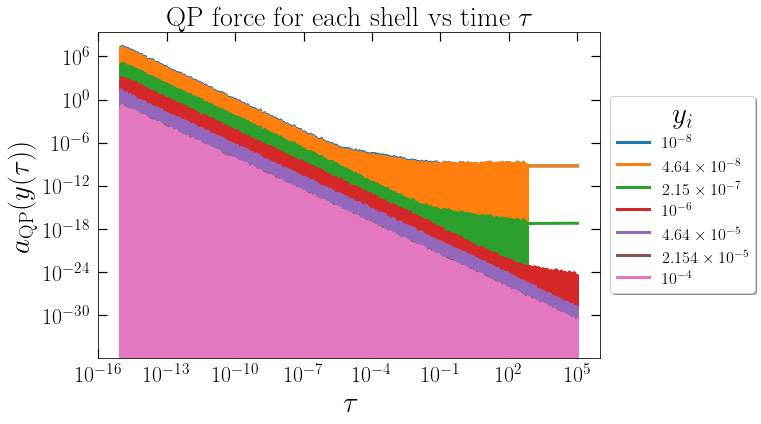

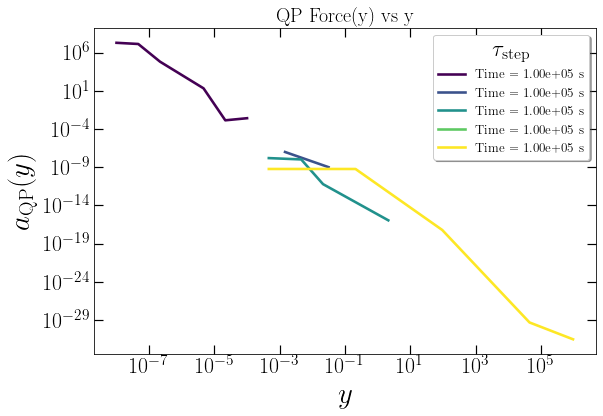

In [56]:
# For each shell, evolution of QP force with time

#Defining the initial conditions

t_i, t_f = 1e-15, 1e5
N = 7
r_min, r_max = 1e-8, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True

t_step = 10000
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])


r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP)


fig, ax = plt.subplots(figsize=(9, 6))
plt.rc('lines', linewidth= 3)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

#colors = cm.plasma(np.linspace(0, 1, N))



for j in range(N):  
    qp_force_arr = []
    for i in range(len(t_arr)):
        rho_arr = rho_sol[:, i]
        r_arr = r_sol[:, i]
        qp_value = qp_force_numerical(rho_arr, r_arr)
        qp_force_arr.append(qp_value[j])
    ax.loglog(t_arr,  np.array(qp_force_arr), color = colors[j])

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9) 

plt.xlabel(r'$\tau$', fontsize= 29, labelpad = 6)
plt.ylabel(r'$a_{\mathrm{QP}}(y(\tau))$', fontsize= 29, labelpad = 6)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend([r'$10^{-8}$', r'$4.64\times10^{-8}$', r'$2.15\times10^{-7}$', r'$10^{-6}$', 
                                                                   r'$4.64\times10^{-5}$', r'$ 2.154\times10^{-5}$', r'$10^{-4}$'],prop = {'size':16.2},
              loc = (1.02, 0.2),shadow = True, title = '$y_{i}$' ,title_fontsize = 29,
           facecolor = 'white',fontsize = 25)

plt.title(r'QP force for each shell vs time $\tau$', fontsize= 28)
plt.savefig('QPforces_vs_tau1a.pdf', bbox_inches = 'tight')
plt.show()






# QP force vs y (for all the shells ) at different time steps in range of 
# time = (t_i, t_f, t_step)

fig, ax = plt.subplots(figsize=(9, 6))
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')

time_indices = np.linspace(0, t_step - 1, 5, dtype=int)
colors = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

for k, idx in enumerate(time_indices):
    rho_arr = rho_sol[:, idx]
    r_arr = r_sol[:, idx]
    qp_val = qp_force_numerical(rho_arr, r_arr)

    mask = (r_arr > 0) & (qp_val > 0) & np.isfinite(qp_val)
    r_filtered = r_arr[mask]
    qp_filtered = qp_val[mask]

    sorted_indices = np.argsort(r_filtered)
    r_sorted = r_filtered[sorted_indices]
    qp_sorted = qp_filtered[sorted_indices]

    ax.loglog(r_sorted, qp_sorted, label=f'Time = {t_arr[t_idx]:.2e} s', color=colors[k])

    for shell_index in range(N-1):
        shell_color = colors_shell[shell_index % len(colors_shell)]
        #ax.scatter(r_arr[shell_index], qp_val[shell_index],
                   #edgecolor='black', s=70, zorder=5, color= shell_color)

ax.set_xlabel(r'$y$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$a_{\mathrm{QP}}(y)$', fontsize=29, labelpad=6)
ax.set_title(f'QP Force(y) vs y ', fontsize=20)
ax.legend(prop={'size': 13.2}, loc='upper right', shadow=True,
          title=r'$\tau_\mathrm{step}$', title_fontsize=23, facecolor='white', fontsize=13.2)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.savefig('qp_vs_r_N7a.pdf', bbox_inches='tight')
plt.show()





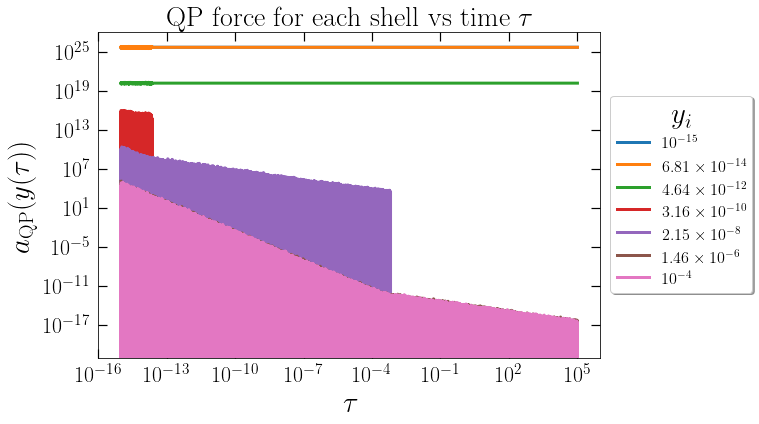

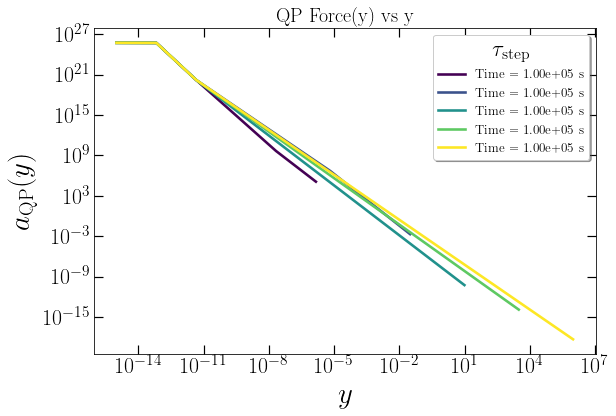

In [57]:
# For each shell, evolution of QP force with time

#Defining the initial conditions

t_i, t_f = 1e-15, 1e5
N = 7
r_min, r_max = 1e-15, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True

t_step = 10000
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])


r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP)


fig, ax = plt.subplots(figsize=(9, 6))
plt.rc('lines', linewidth= 3)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
#colors = cm.plasma(np.linspace(0, 1, N))



for j in range(N):  
    qp_force_arr = []
    for i in range(len(t_arr)):
        rho_arr = rho_sol[:, i]
        r_arr = r_sol[:, i]
        qp_value = qp_force_numerical(rho_arr, r_arr)
        qp_force_arr.append(qp_value[j])
    
    
    ax.loglog(t_arr,  qp_force_arr, color = colors[j])

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9) 

plt.xlabel(r'$\tau$', fontsize= 29, labelpad = 6)
plt.ylabel(r'$a_{\mathrm{QP}}(y(\tau))$', fontsize= 29, labelpad = 6)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)


plt.legend([r'$10^{-15}$', r'$6.81\times10^{-14}$', r'$4.64\times10^{-12}$', 
     r'$3.16\times10^{-10}$', r'$2.15\times10^{-8}$', r'$1.46\times10^{-6}$',
            r'$10^{-4}$', ],
    prop = {'size':16.2},loc = (1.02, 0.2),shadow = True, title = '$y_{i}$' ,
    title_fontsize = 29, facecolor = 'white',fontsize = 25)

plt.title(r'QP force for each shell vs time $\tau$', fontsize= 28)
plt.savefig('QPforces_vs_tau1b.pdf', bbox_inches = 'tight')
plt.show()





# QP force vs y (for all the shells ) at different time steps in range of 
# time = (t_i, t_f, t_step)

fig, ax = plt.subplots(figsize=(9, 6))
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')

time_indices = np.linspace(0, t_step - 1, 5, dtype=int)
colors = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

for k, idx in enumerate(time_indices):
    rho_arr = rho_sol[:, idx]
    r_arr = r_sol[:, idx]
    qp_val = qp_force_numerical(rho_arr, r_arr)

    mask = (r_arr > 0) & (qp_val > 0) & np.isfinite(qp_val)
    r_filtered = r_arr[mask]
    qp_filtered = qp_val[mask]

    sorted_indices = np.argsort(r_filtered)
    r_sorted = r_filtered[sorted_indices]
    qp_sorted = qp_filtered[sorted_indices]

    ax.loglog(r_sorted, qp_sorted, label=f'Time = {t_arr[t_idx]:.2e} s', color=colors[k])

    for shell_index in range(N-1):
        shell_color = colors_shell[shell_index % len(colors_shell)]
        #ax.scatter(r_arr[shell_index], qp_val[shell_index],
                   #edgecolor='black', s=70, zorder=5, color= shell_color)

ax.set_xlabel(r'$y$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$a_{\mathrm{QP}}(y)$', fontsize=29, labelpad=6)
ax.set_title(f'QP Force(y) vs y ', fontsize=20)
ax.legend(prop={'size': 13.2}, loc='upper right', shadow=True,
          title=r'$\tau_\mathrm{step}$', title_fontsize=23, facecolor='white', fontsize=13.2)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.savefig('qp_vs_r_N7b.pdf', bbox_inches='tight')
plt.show()


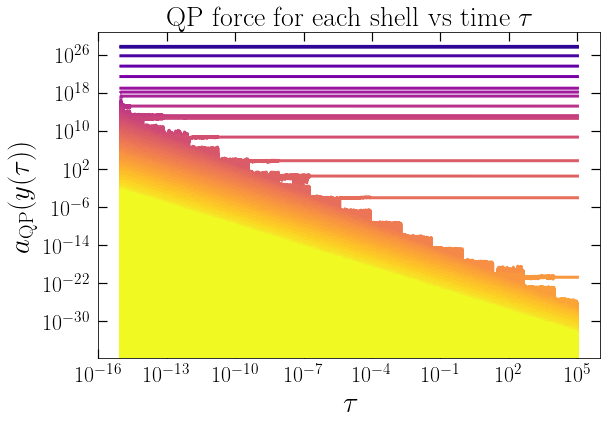

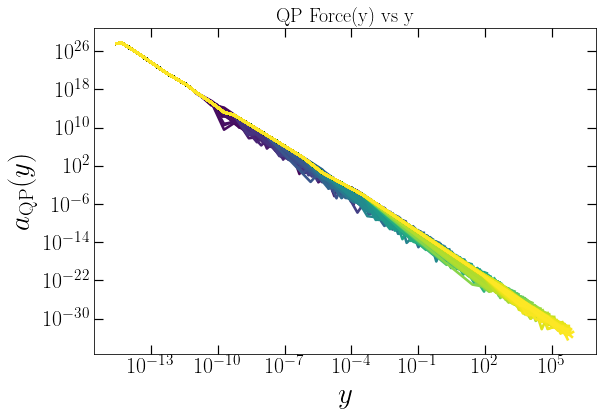

In [93]:
# For each shell, evolution of QP force with time

#Defining the initial conditions

t_i, t_f = 1e-15, 1e5
N = 50
r_min, r_max = 1e-15, 1e-4
ri_arr = np.geomspace(r_min, r_max, N)
initial_density = 1e-20


delta_M_arr = shells_mass(ri_arr, N, initial_density)
QP = True
gravity = True
Hubble = True

t_step = 10000
t_arr = np.geomspace(t_i, t_f, t_step)
dt = np.gradient(t_arr)

r_sol = np.zeros((N, len(t_arr)))
v_sol = np.zeros((N, len(t_arr)))
rho_sol = np.zeros((N, len(t_arr)))
mask_active = np.ones(N, dtype=bool)
cutoff_index = np.full(N, len(t_arr))
t_ta_arr = np.full(N, np.nan)
r_ta_arr = np.full(N, np.nan)
turnaround_detected = np.zeros(N, dtype=bool)
r_sol[:, 0] = ri_arr
v_sol[:, 0] = ri_arr/(2 * t_arr[0])


r_sol, v_sol, rho_sol, QP_arr, cutoff_index, r_ta_arr, t_ta_arr, rho_arr, rta_mask, tta_mask = shells_evolution(N, t_arr, dt, ri_arr, Hubble, gravity, QP)


fig, ax = plt.subplots(figsize=(9, 6))
plt.rc('lines', linewidth= 3)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')
#colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
colors = cm.plasma(np.linspace(0, 1, N))



for j in range(N):  
    qp_force_arr = []
    for i in range(len(t_arr)):
        rho_arr = rho_sol[:, i]
        r_arr = r_sol[:, i]
        qp_value = qp_force_numerical(rho_arr, r_arr)
        qp_force_arr.append(qp_value[j])
    ax.loglog(t_arr,  qp_force_arr, color = colors[j])

ax.tick_params(axis='x', pad=7.9)
ax.tick_params(axis='y', pad=7.9) 

plt.xlabel(r'$\tau$', fontsize= 29, labelpad = 6)
plt.ylabel(r'$a_{\mathrm{QP}}(y(\tau))$', fontsize= 29, labelpad = 6)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)


#plt.legend([r'$10^{-15}$', r'$6.81\times10^{-14}$', r'$4.64\times10^{-12}$', 
    # r'$3.16\times10^{-10}$', r'$2.15\times10^{-8}$', r'$1.46\times10^{-6}$',
          #  r'$10^{-4}$', ],
   # prop = {'size':16.2},loc = (1.02, 0.2),shadow = True, title = '$y_{i}$' ,
    #title_fontsize = 29, facecolor = 'white',fontsize = 25)

plt.title(r'QP force for each shell vs time $\tau$', fontsize= 28)
#plt.savefig('QPforces_vs_tau1b.pdf', bbox_inches = 'tight')
plt.show()





# QP force vs y (for all the shells ) at different time steps in range of 
# time = (t_i, t_f, t_step)

fig, ax = plt.subplots(figsize=(9, 6))
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')

time_indices = np.linspace(0, t_step - 1, 1000, dtype=int)
colors = cm.viridis(np.linspace(0, 1, len(time_indices)))
colors_shell = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']

for k, idx in enumerate(time_indices):
    rho_arr = rho_sol[:, idx]
    r_arr = r_sol[:, idx]
    qp_val = qp_force_numerical(rho_arr, r_arr)
    
    mask = (r_arr > 0) & (qp_val > 0) & np.isfinite(qp_val)
    r_filtered = r_arr[mask]
    qp_filtered = qp_val[mask]

    sorted_indices = np.argsort(r_filtered)
    r_sorted = r_filtered[sorted_indices]
    qp_sorted = qp_filtered[sorted_indices]

    ax.loglog(r_sorted, qp_sorted, label=f'Time = {t_arr[t_idx]:.2e} s', color=colors[k])


    for shell_index in range(N-1):
        shell_color = colors_shell[shell_index % len(colors_shell)]
        #ax.scatter(r_arr[shell_index], qp_val[shell_index],
                   #edgecolor='black', s=70, zorder=5, color= shell_color)

ax.set_xlabel(r'$y$', fontsize=29, labelpad=6)
ax.set_ylabel(r'$a_{\mathrm{QP}}(y)$', fontsize=29, labelpad=6)
ax.set_title(f'QP Force(y) vs y ', fontsize=20)
#ax.legend(prop={'size': 13.2}, loc='upper right', shadow=True,
        #  title=r'$\tau_\mathrm{step}$', title_fontsize=23, facecolor='white', fontsize=13.2)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
#plt.savefig('qp_vs_r_N7b.pdf', bbox_inches='tight')
plt.show()





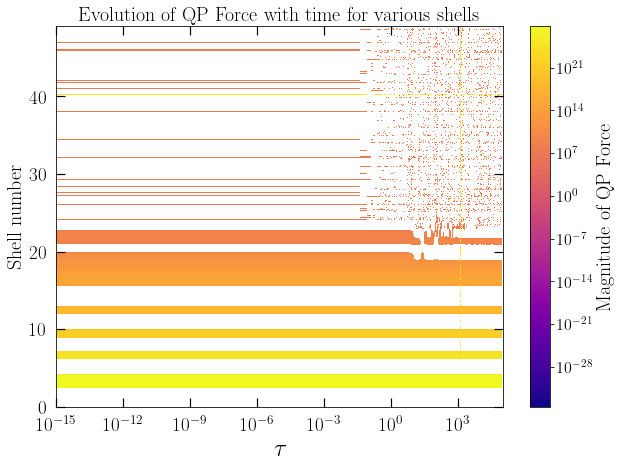

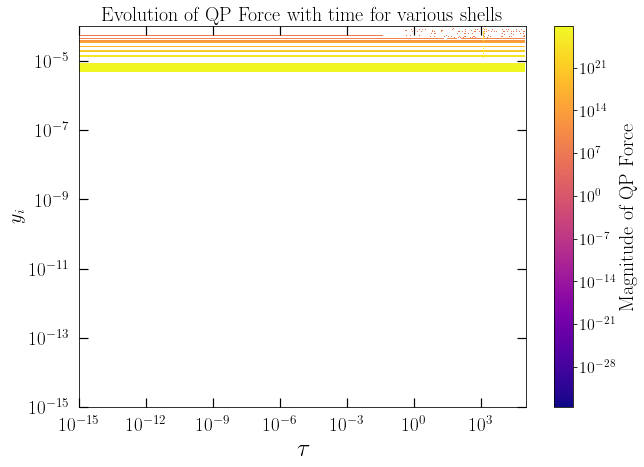

In [98]:
qp_matrix = np.zeros((N, len(t_arr)))
for i in range(len(t_arr)):
    rho_arr = rho_sol[:, i]
    r_arr = r_sol[:, i]
    qp_val = qp_force_numerical(rho_arr, r_arr)
    qp_matrix[:, i] = qp_val
    
    


fig, ax = plt.subplots(figsize=(10, 7))
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')

im = ax.imshow(qp_matrix, aspect='auto', extent=[t_arr[0], t_arr[-1], 0, N-1], 
               origin='lower', cmap='plasma', norm=LogNorm())

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Magnitude of QP Force', fontsize=20)
cbar.ax.tick_params(labelsize=16)


ax.tick_params(axis='x', pad=9.9)
ax.tick_params(axis='y', pad=9.9)  
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel(r'$\tau$', fontsize=25)
plt.ylabel('Shell number', fontsize=20)
plt.title('Evolution of QP Force with time for various shells', fontsize = 20)
plt.xscale('log')
plt.savefig('rhocolormap.pdf', bbox_inches = 'tight')
plt.show()



qp_matrix = np.zeros((N, len(t_arr)))
for i in range(len(t_arr)):
    rho_arr = rho_sol[:, i]
    r_arr = r_sol[:, i]
    qp_val = qp_force_numerical(rho_arr, r_arr)
    qp_matrix[:, i] = qp_val


T, R = np.meshgrid(t_arr, ri_arr)  
fig, ax = plt.subplots(figsize=(10, 7))
plt.rc('lines', linewidth=2.6)
plt.tick_params(axis='both', right=True, top=True, which='minor', width=1.2, length=4, direction='in')
plt.tick_params(axis='both', right=True, top=True, which='major', width=1.2, length=9, direction='in')

im = ax.imshow(qp_matrix, aspect='auto',
           extent=[t_arr[0], t_arr[-1], ri_arr[0], ri_arr[-1]],
           origin='lower',
           cmap='plasma',
           norm=LogNorm())



cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Magnitude of QP Force', fontsize=20)
cbar.ax.tick_params(labelsize=16)
ax.tick_params(axis='x', pad=9.9)
ax.tick_params(axis='y', pad=9.9)  
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
plt.xlabel(r'$\tau$', fontsize=25)
plt.ylabel('$y_i$', fontsize=20)
plt.title('Evolution of QP Force with time for various shells', fontsize = 20)
plt.xscale('log')
plt.yscale('log')
#plt.savefig('rhocolormap.pdf', bbox_inches = 'tight')
plt.show()



